=== Финальный Feature Engineering для больших данных ===

1. Загрузка данных с оптимизацией памяти...
✅ Данные загружены: (15812995, 17)
Начальный объем памяти: 16538.52 MB
Конечный объем памяти: 16478.20 MB
Экономия: 0.4%

2. Создание целевой переменной...
📊 Распределение типов конверсий:
  no_conversion: 15710153 (99.35%)
  car_claim: 37267 (0.24%)
  open_dialog: 25492 (0.16%)
  submit_success: 17941 (0.11%)
  car_claim_submit: 12165 (0.08%)
  call_number: 3638 (0.02%)
  callback: 2949 (0.02%)
  car_request: 2783 (0.02%)
  custom_question: 607 (0.00%)

3. Создание базовых фич...
✅ Базовые фичи созданы

4. Создание UTM фич...
✅ UTM фичи созданы

5. Создание device фич...
✅ Device фичи созданы

6. Создание временных фич...
✅ Временные фичи созданы

7. Создание session features...
  Вычисление session aggregates...
Начальный объем памяти: 217.97 MB
Конечный объем памяти: 170.08 MB
Экономия: 22.0%
  Объединение с основными данными...
✅ Session фичи созданы

8. Создание user features...
 

C:\Users\Александр\AppData\Local\Temp\ipykernel_21872\3029208009.py:409: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  device_cr = viz_sample.groupby('device_category')['target'].mean()
C:\Users\Александр\AppData\Local\Temp\ipykernel_21872\3029208009.py:415: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_cr = viz_sample.groupby('time_of_day')['target'].mean()
C:\Users\Александр\AppData\Local\Temp\ipykernel_21872\3029208009.py:420: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=

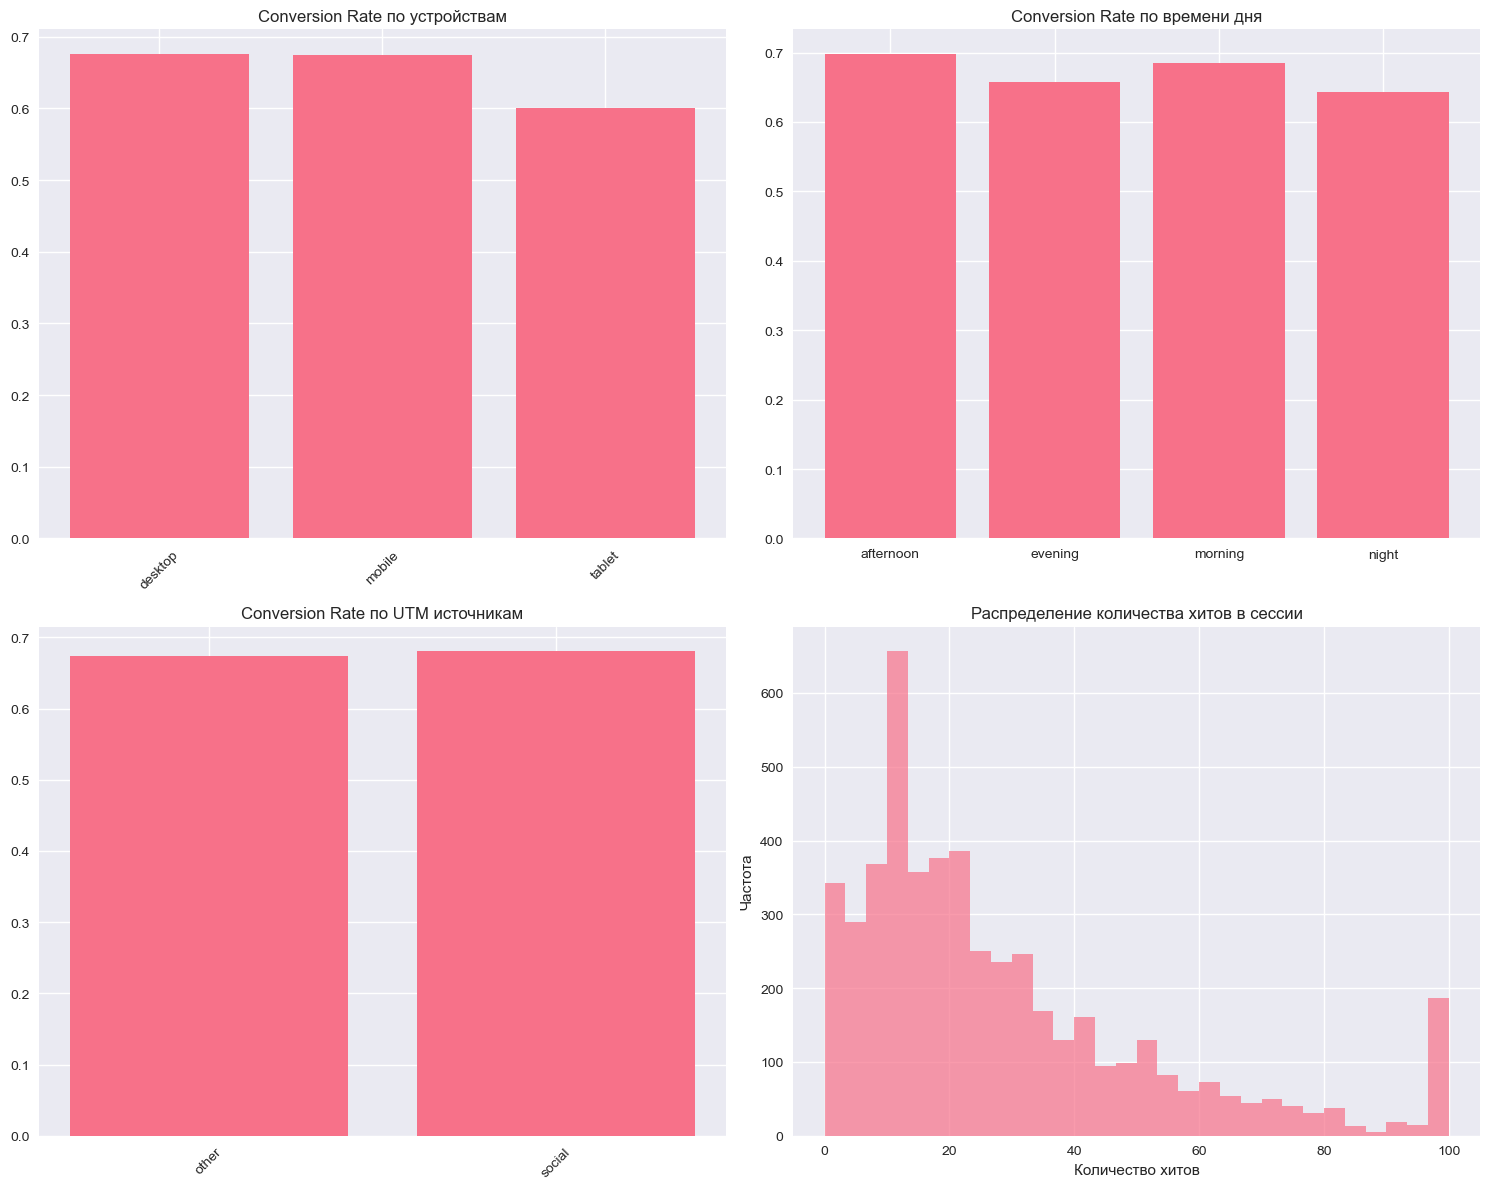


ФИНАЛЬНАЯ СВОДКА FEATURE ENGINEERING
📊 ДАННЫЕ:
   • Исходный размер: (15812995, 38)
   • Финальный размер: (15812995, 21)
   • Размер сэмпла: (152842, 21)
   • Количество фич: 21
   • Conversion rate: 0.0065

🎯 СОЗДАННЫЕ ФИЧИ:
   UTM: 2 фич
   Device: 3 фич
   Temporal: 8 фич
   Behavioral: 5 фич
   Event: 1 фич
   Geo: 1 фич

💾 СОХРАНЕННЫЕ ФАЙЛЫ:
   • model_data_final.csv - полные данные ((15812995, 21))
   • model_data_sample.csv - сэмпл для обучения ((152842, 21))
   • plots/final_feature_analysis.png - визуализация

✅ FEATURE ENGINEERING УСПЕШНО ЗАВЕРШЕН!


51

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import re
import os
from datetime import datetime
import gc

# Настройки для экономии памяти
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("=== Финальный Feature Engineering для больших данных ===\n")

# Функция для уменьшения использования памяти (без автоматического category)
def reduce_memory_usage(df, use_category=True):
    """Уменьшает использование памяти DataFrame"""
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    print(f"Начальный объем памяти: {start_mem:.2f} MB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type == 'object' and use_category:
            # Для категориальных данных используем category если уникальных значений немного
            num_unique = df[col].nunique()
            if num_unique < len(df) * 0.5:  # Если уникальных значений меньше 50%
                df[col] = df[col].astype('category')
                
        elif col_type.name in ['float64', 'float32']:
            # Преобразуем float к float32
            df[col] = df[col].astype('float32')
            
        elif col_type.name in ['int64', 'int32']:
            # Находим подходящий int тип
            c_min = df[col].min()
            c_max = df[col].max()
            
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype('int8')
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype('int16')
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype('int32')
    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    print(f"Конечный объем памяти: {end_mem:.2f} MB")
    print(f"Экономия: {(start_mem - end_mem) / start_mem * 100:.1f}%")
    
    return df

# 1. Загрузка данных с оптимизацией памяти (без category)
print("1. Загрузка данных с оптимизацией памяти...")

try:
    # Загружаем только нужные колонки для экономии памяти
    essential_columns = [
        'session_id', 'client_id', 'visit_date', 'visit_time', 'utm_source', 
        'utm_medium', 'device_category', 'device_os', 'device_brand', 
        'device_screen_resolution', 'device_browser', 'geo_country', 'geo_city',
        'event_action', 'event_category', 'hit_number', 'hit_page_path'
    ]
    
    # Загружаем данные с указанием типов для проблемных колонок
    data = pd.read_csv('ga_data_processed.csv', 
                      usecols=essential_columns,
                      dtype={'client_id': 'str'})  # Указываем проблемную колонку как string
    
    print(f"✅ Данные загружены: {data.shape}")
    
    # Оптимизируем использование памяти (БЕЗ автоматического category)
    data = reduce_memory_usage(data, use_category=False)
    
except FileNotFoundError:
    print("❌ Файл ga_data_processed.csv не найден")
    raise

# 2. Создание целевой переменной
print("\n2. Создание целевой переменной...")

conversion_events = {
    'sub_car_claim_click': 'car_claim',
    'sub_car_claim_submit_click': 'car_claim_submit', 
    'sub_open_dialog_click': 'open_dialog',
    'sub_custom_question_submit_click': 'custom_question',
    'sub_call_number_click': 'call_number',
    'sub_callback_submit_click': 'callback',
    'sub_submit_success': 'submit_success',
    'sub_car_request_submit_click': 'car_request'
}

data['conversion_type'] = data['event_action'].map(conversion_events)
data['conversion_type'] = data['conversion_type'].fillna('no_conversion')
data['target'] = (data['conversion_type'] != 'no_conversion').astype('int8')

print("📊 Распределение типов конверсий:")
conversion_dist = data['conversion_type'].value_counts()
for conv_type, count in conversion_dist.head(10).items():
    print(f"  {conv_type}: {count} ({count/len(data)*100:.2f}%)")

# Освобождаем память
del conversion_dist
gc.collect()

# 3. Базовые фичи с правильной обработкой
print("\n3. Создание базовых фич...")

# Сначала заполняем пропуски в object колонках
object_columns = data.select_dtypes(include=['object']).columns
for col in object_columns:
    data[col] = data[col].fillna('unknown')

# Теперь конвертируем выбранные колонки в category
columns_to_category = ['utm_source', 'utm_medium', 'device_category', 'device_os', 'device_browser']
for col in columns_to_category:
    if col in data.columns:
        data[col] = data[col].astype('category')

print("✅ Базовые фичи созданы")

# 4. UTM features
print("\n4. Создание UTM фич...")

def classify_utm_source(source):
    social_sources = [
        'QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt', 'ISrKoXQCxqqYvAZICvjs',
        'IZEXUFLARCUMynmHNBGo', 'PlbkrSYoHuZBWfYjYnfw', 'gVRrcxiDQubJiljoTbGm'
    ]
    
    source_str = str(source)
    if source_str in social_sources:
        return 'social'
    elif source_str == 'unknown':
        return 'unknown'
    elif source_str == '(direct)':
        return 'direct'
    elif 'organic' in source_str.lower():
        return 'organic'
    else:
        return 'other'

# Применяем функцию к string представлению
data['utm_source_type'] = data['utm_source'].astype(str).apply(classify_utm_source)
data['utm_source_type'] = data['utm_source_type'].astype('category')

print("✅ UTM фичи созданы")

# 5. Device features
print("\n5. Создание device фич...")

def classify_os(os):
    os_str = str(os)
    mobile_os = ['Android', 'iOS']
    desktop_os = ['Windows', 'Macintosh', 'Linux', 'Chrome OS']
    
    if os_str in mobile_os:
        return 'mobile'
    elif os_str in desktop_os:
        return 'desktop'
    elif os_str == 'unknown':
        return 'unknown'
    else:
        return 'other'

data['os_type'] = data['device_os'].astype(str).apply(classify_os)
data['os_type'] = data['os_type'].astype('category')

print("✅ Device фичи созданы")

# 6. Временные фичи
print("\n6. Создание временных фич...")

# Обработка даты и времени
if 'visit_date' in data.columns:
    data['visit_date'] = pd.to_datetime(data['visit_date'])
    data['day_of_week'] = data['visit_date'].dt.dayofweek.astype('int8')
    data['month'] = data['visit_date'].dt.month.astype('int8')
    data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype('int8')

if 'visit_time' in data.columns:
    try:
        # Более безопасная обработка времени
        data['hour_of_day'] = pd.to_datetime(data['visit_time'], format='%H:%M:%S', errors='coerce').dt.hour
        data['hour_of_day'] = data['hour_of_day'].fillna(12).astype('int8')
    except Exception as e:
        print(f"⚠️ Ошибка обработки времени: {e}")
        data['hour_of_day'] = 12

# Циклические фичи
data['hour_sin'] = np.sin(2 * np.pi * data['hour_of_day']/24).astype('float32')
data['hour_cos'] = np.cos(2 * np.pi * data['hour_of_day']/24).astype('float32')

def classify_time_of_day(hour):
    if 5 <= hour <= 11:
        return 'morning'
    elif 12 <= hour <= 16:
        return 'afternoon'
    elif 17 <= hour <= 21:
        return 'evening'
    else:
        return 'night'

data['time_of_day'] = data['hour_of_day'].apply(classify_time_of_day)
data['time_of_day'] = data['time_of_day'].astype('category')
data['is_peak_hours'] = ((data['hour_of_day'] >= 9) & (data['hour_of_day'] <= 18)).astype('int8')

print("✅ Временные фичи созданы")

# 7. Session features (оптимизировано для больших данных)
print("\n7. Создание session features...")

# Используем более эффективный подход для больших данных
print("  Вычисление session aggregates...")

# Группируем по session_id и считаем агрегаты
session_aggregates = data.groupby('session_id').agg({
    'target': 'max',
    'hit_number': 'count',
    'event_category': lambda x: x.nunique(),
    'event_action': lambda x: x.nunique(), 
    'hit_page_path': lambda x: x.nunique()
}).reset_index()

session_aggregates.columns = [
    'session_id', 'session_converted', 'session_hits_count', 
    'unique_event_categories', 'unique_event_actions', 'unique_pages'
]

# Оптимизируем типы данных
session_aggregates = reduce_memory_usage(session_aggregates, use_category=False)

# Объединяем с основными данными
print("  Объединение с основными данными...")
data = data.merge(session_aggregates, on='session_id', how='left')

# Освобождаем память
del session_aggregates
gc.collect()

print("✅ Session фичи созданы")

# 8. User features
print("\n8. Создание user features...")

# Более эффективный подсчет сессий на пользователя
print("  Вычисление user session counts...")

# Берем уникальные пары client_id - session_id
user_sessions = data[['client_id', 'session_id']].drop_duplicates()

# Группируем и считаем
user_session_count = user_sessions.groupby('client_id').size().reset_index()
user_session_count.columns = ['client_id', 'total_sessions']
user_session_count['total_sessions'] = user_session_count['total_sessions'].astype('int16')

# Объединяем с основными данными
data = data.merge(user_session_count, on='client_id', how='left')
data['is_returning_user'] = (data['total_sessions'] > 1).astype('int8')

# Освобождаем память
del user_sessions, user_session_count
gc.collect()

print("✅ User фичи созданы")

# 9. Event features
print("\n9. Создание event features...")

def classify_event_category(category):
    if pd.isna(category):
        return 'unknown'
    
    category_str = str(category).lower()
    
    if 'sub' in category_str and 'click' in category_str:
        return 'submission_click'
    elif 'sub' in category_str and 'submit' in category_str:
        return 'submission_submit'
    elif 'page' in category_str or 'view' in category_str:
        return 'page_view'
    elif 'click' in category_str:
        return 'engagement_click'
    elif 'scroll' in category_str:
        return 'engagement_scroll'
    else:
        return 'other'

data['event_category_group'] = data['event_category'].apply(classify_event_category)
data['event_category_group'] = data['event_category_group'].astype('category')

print("✅ Event фичи созданы")

# 10. Geo features
print("\n10. Создание geo features...")

# Заполняем пропуски и конвертируем
data['geo_country'] = data['geo_country'].fillna('unknown').astype('category')
data['geo_city'] = data['geo_city'].fillna('unknown').astype('category')

def classify_country(country):
    country_str = str(country)
    cis_countries = ['Russia', 'Ukraine', 'Belarus', 'Kazakhstan']
    european_countries = ['Germany', 'France', 'United Kingdom', 'Italy', 'Spain']
    
    if country_str in cis_countries:
        return 'cis'
    elif country_str in european_countries:
        return 'europe'
    elif country_str == 'unknown':
        return 'unknown'
    else:
        return 'other'

data['country_region'] = data['geo_country'].apply(classify_country)
data['country_region'] = data['country_region'].astype('category')

print("✅ Geo фичи созданы")

# 11. Финальная оптимизация памяти
print("\n11. Финальная оптимизация памяти...")
data = reduce_memory_usage(data, use_category=False)

# 12. Сохранение данных для модели
print("\n12. Сохранение данных для модели...")

# Выбираем только самые важные фичи для экономии памяти
essential_model_features = [
    # UTM
    'utm_source_type', 'utm_medium',
    
    # Device
    'device_category', 'os_type', 'device_browser',
    
    # Temporal
    'day_of_week', 'hour_of_day', 'hour_sin', 'hour_cos', 
    'time_of_day', 'is_weekend', 'month', 'is_peak_hours',
    
    # Behavioral
    'session_hits_count', 'unique_event_categories', 
    'unique_event_actions', 'unique_pages', 'is_returning_user',
    
    # Event
    'event_category_group',
    
    # Geo
    'country_region',
    
    # Target
    'target'
]

# Создаем финальный датасет
model_data = data[essential_model_features].copy()

# Удаляем строки с пропусками
initial_size = len(model_data)
model_data = model_data.dropna()
final_size = len(model_data)

print(f"Размер после удаления пропусков: {final_size} (удалено {initial_size - final_size} строк)")

# Финальная оптимизация
model_data = reduce_memory_usage(model_data, use_category=False)

# Сохраняем данные
model_data.to_csv('model_data_final.csv', index=False)
print("✅ Финальные данные сохранены в model_data_final.csv")

# 13. Сэмплирование для быстрого прототипирования
print("\n13. Создание сэмпла для быстрого обучения...")

# Создаем сбалансированный сэмпл для быстрого тестирования
conversions = model_data[model_data['target'] == 1]
non_conversions = model_data[model_data['target'] == 0]

print(f"Конверсий: {len(conversions)}")
print(f"Не конверсий: {len(non_conversions)}")

# Берем сэмпл разумного размера
sample_size = min(50000, len(non_conversions))
non_conversions_sample = non_conversions.sample(n=sample_size, random_state=42)

# Создаем сбалансированный сэмпл
balanced_sample = pd.concat([
    conversions,
    non_conversions_sample
], axis=0).sample(frac=1, random_state=42)  # shuffle

balanced_sample.to_csv('model_data_sample.csv', index=False)
print(f"✅ Сэмпл данных сохранен в model_data_sample.csv: {balanced_sample.shape}")

# 14. Быстрая визуализация
print("\n14. Быстрая визуализация ключевых метрик...")

os.makedirs('plots', exist_ok=True)

# Используем небольшой сэмпл для визуализации
viz_sample = balanced_sample.sample(n=min(5000, len(balanced_sample)), random_state=42)

try:
    # Базовые распределения
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Conversion rate по device
    device_cr = viz_sample.groupby('device_category')['target'].mean()
    axes[0, 0].bar(device_cr.index, device_cr.values)
    axes[0, 0].set_title('Conversion Rate по устройствам')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Conversion rate по времени
    time_cr = viz_sample.groupby('time_of_day')['target'].mean()
    axes[0, 1].bar(time_cr.index, time_cr.values)
    axes[0, 1].set_title('Conversion Rate по времени дня')
    
    # Conversion rate по UTM
    utm_cr = viz_sample.groupby('utm_source_type')['target'].mean()
    axes[1, 0].bar(utm_cr.index, utm_cr.values)
    axes[1, 0].set_title('Conversion Rate по UTM источникам')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Session hits distribution
    axes[1, 1].hist(viz_sample['session_hits_count'].clip(0, 100), bins=30, alpha=0.7)
    axes[1, 1].set_title('Распределение количества хитов в сессии')
    axes[1, 1].set_xlabel('Количество хитов')
    axes[1, 1].set_ylabel('Частота')
    
    plt.tight_layout()
    plt.savefig('plots/final_feature_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
except Exception as e:
    print(f"⚠️ Ошибка при визуализации: {e}")

# 15. Финальная сводка
print("\n" + "="*60)
print("ФИНАЛЬНАЯ СВОДКА FEATURE ENGINEERING")
print("="*60)

print(f"📊 ДАННЫЕ:")
print(f"   • Исходный размер: {data.shape}")
print(f"   • Финальный размер: {model_data.shape}")
print(f"   • Размер сэмпла: {balanced_sample.shape}")
print(f"   • Количество фич: {len(model_data.columns)}")
print(f"   • Conversion rate: {model_data['target'].mean():.4f}")

print(f"\n🎯 СОЗДАННЫЕ ФИЧИ:")
feature_groups = {
    'UTM': ['utm_source_type', 'utm_medium'],
    'Device': ['device_category', 'os_type', 'device_browser'],
    'Temporal': ['day_of_week', 'hour_of_day', 'hour_sin', 'hour_cos', 'time_of_day', 'is_weekend', 'month', 'is_peak_hours'],
    'Behavioral': ['session_hits_count', 'unique_event_categories', 'unique_event_actions', 'unique_pages', 'is_returning_user'],
    'Event': ['event_category_group'],
    'Geo': ['country_region']
}

for group, features in feature_groups.items():
    existing_features = [f for f in features if f in model_data.columns]
    print(f"   {group}: {len(existing_features)} фич")

print(f"\n💾 СОХРАНЕННЫЕ ФАЙЛЫ:")
print(f"   • model_data_final.csv - полные данные ({model_data.shape})")
print(f"   • model_data_sample.csv - сэмпл для обучения ({balanced_sample.shape})")
print(f"   • plots/final_feature_analysis.png - визуализация")

print(f"\n✅ FEATURE ENGINEERING УСПЕШНО ЗАВЕРШЕН!")
print("="*60)

# Освобождаем память
del data, model_data, balanced_sample, viz_sample
gc.collect()